Final Project codes

For my final project, I decided to look and plot delft3D output

In [2]:
# various import statements
import os #to read the file path
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr # to read in the netcdf file Delft3D output
from scipy.spatial import cKDTree
from scipy import stats
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from pyproj import Proj
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import contextily as ctx
import cmocean # for specific color scale
import dfm_tools as dfmt # Delft3D package for reading in codes

C:\Users\sbrann5\AppData\Local\anaconda3again\envs\OCS4001\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [127]:
# This sections defines the Delft3D output file path, and brings it into jupyter as an xarray

#file_location=r"C:\Users\sbrann5\OneDrive - Louisiana State University\3_Western_Scheldt\02_Final_models_incl_output\Western_Scheldt_d.dsproj_data\FlowFM\output\FlowFM_map.nc"
file_location=r"C:\Users\sbrann5\Downloads\FlowFM_map_100.nc"
map_xr = xr.open_dataset(file_location)
map_xr.rename({})


<xarray.Dataset> Size: 274MB
Dimensions:                       (mesh2d_nNodes: 6285, mesh2d_nEdges: 12362,
                                   Two: 2, mesh2d_nFaces: 6078,
                                   mesh2d_nMax_face_nodes: 4, time: 73,
                                   nSedTot: 2, nSedSus: 2)
Coordinates:
    mesh2d_node_x                 (mesh2d_nNodes) float64 50kB ...
    mesh2d_node_y                 (mesh2d_nNodes) float64 50kB ...
    mesh2d_edge_x                 (mesh2d_nEdges) float64 99kB ...
    mesh2d_edge_y                 (mesh2d_nEdges) float64 99kB ...
    mesh2d_face_x                 (mesh2d_nFaces) float64 49kB ...
    mesh2d_face_y                 (mesh2d_nFaces) float64 49kB ...
  * time                          (time) datetime64[ns] 584B 2002-12-22 ... 2...
Dimensions without coordinates: mesh2d_nNodes, mesh2d_nEdges, Two,
                                mesh2d_nFaces, mesh2d_nMax_face_nodes, nSedTot,
                                nSedSus
Data variables: (12/67)
    projected_coordinate_system   int32 4B ...
    mesh2d                        int32 4B ...
    mesh2d_node_z                 (mesh2d_nNodes) float64 50kB ...
    mesh2d_edge_nodes             (mesh2d_nEdges, Two) int32 99kB ...
    mesh2d_face_nodes             (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 194kB ...
    mesh2d_edge_faces             (mesh2d_nEdges, Two) float64 198kB ...
    ...                            ...
    mesh2d_thetamean              (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_twav                   (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_Fx                     (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_Fy                     (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_wavfu                  (time, mesh2d_nEdges) float64 7MB ...
    mesh2d_wavfv                  (time, mesh2d_nEdges) float64 7MB ...
Attributes:
    institution:               Deltares
    references:                http://www.deltares.nl
    source:                    D-Flow FM 1.2.177.142431. Model:
    history:                   Created on 2023-10-06T16:11:22+0200, D-Flow FM
    date_created:              2023-10-06T16:11:22+0200
    date_modified:             2023-10-06T16:11:22+0200
    Conventions:               CF-1.8 UGRID-1.0 Deltares-0.10 ACDD-1.3
    uuid:                      6d802d2d-975c-1848-9a0b-78efe2533024
    time_coverage_start:       2002-12-22T**:00:00+00:00
    time_coverage_end:         2002-12-25T**:00:00+00:00
    time_coverage_duration:    P0000-00-03T00:00:00
    time_coverage_resolution:  P0000-00-00T01:00:00

The coordinates of the Delft3D output files have data located at the nodes (points on the grid), edges (lines on the grid), and faces (polygon formed by the gridlines). There are different coordinates because certain variables are stored in different ways.

In [128]:
# read in netcdf file using the dfmt 
file_nc = os.path.join(file_location)
uds_map = dfmt.open_partitioned_dataset(file_nc)
uds_map = uds_map.rename({})
map_vars_pd = dfmt.get_ncvarproperties(uds_map)


>> xu.open_dataset() with 1 partition(s): 1 [nodomainvar] : 0.03 sec


In [129]:
# Building a Pandas dataframe that writes all the output variables given by Delft3D, where they are defined, and type of data

nc_varkeys = map_xr.variables.mapping.keys() 
list_varattrs_pd = []
for varkey in nc_varkeys:
    varattrs_pd = pd.DataFrame({varkey:map_xr.variables.mapping[varkey].attrs}).T
    varattrs_pd[['shape','dimensions','dtype']] = 3*[''] 
    varattrs_pd.at[varkey,'shape'] = map_xr[varkey].shape
    varattrs_pd.at[varkey,'dimensions'] = map_xr.variables[varkey].dims
    varattrs_pd.at[varkey,'dtype'] = map_xr.variables[varkey].dtype
    list_varattrs_pd.append(varattrs_pd)
vars_pd = pd.concat(list_varattrs_pd,axis=0)
vars_pd[vars_pd.isnull()] = ''
vars_pd = vars_pd[["standard_name","units","location","shape","dimensions","dtype","long_name"]]

print(vars_pd)

                                        standard_name  units location  \
projected_coordinate_system                                             
mesh2d                                                                  
mesh2d_node_x                 projection_x_coordinate      m            
mesh2d_node_y                 projection_y_coordinate      m            
mesh2d_node_z                                altitude      m     node   
...                                               ...    ...      ...   
mesh2d_twav                   sea_surface_wave_period      s     face   
mesh2d_Fx                    sea_surface_x_wave_force  N m-2     face   
mesh2d_Fy                    sea_surface_y_wave_force  N m-2     face   
mesh2d_wavfu                                           N m-2     edge   
mesh2d_wavfv                                           N m-2     edge   

                                   shape             dimensions    dtype  \
projected_coordinate_system           ()       

In [130]:
# Set figure dimensions
fig_width = 10
fig_height = 4
font_size = 12

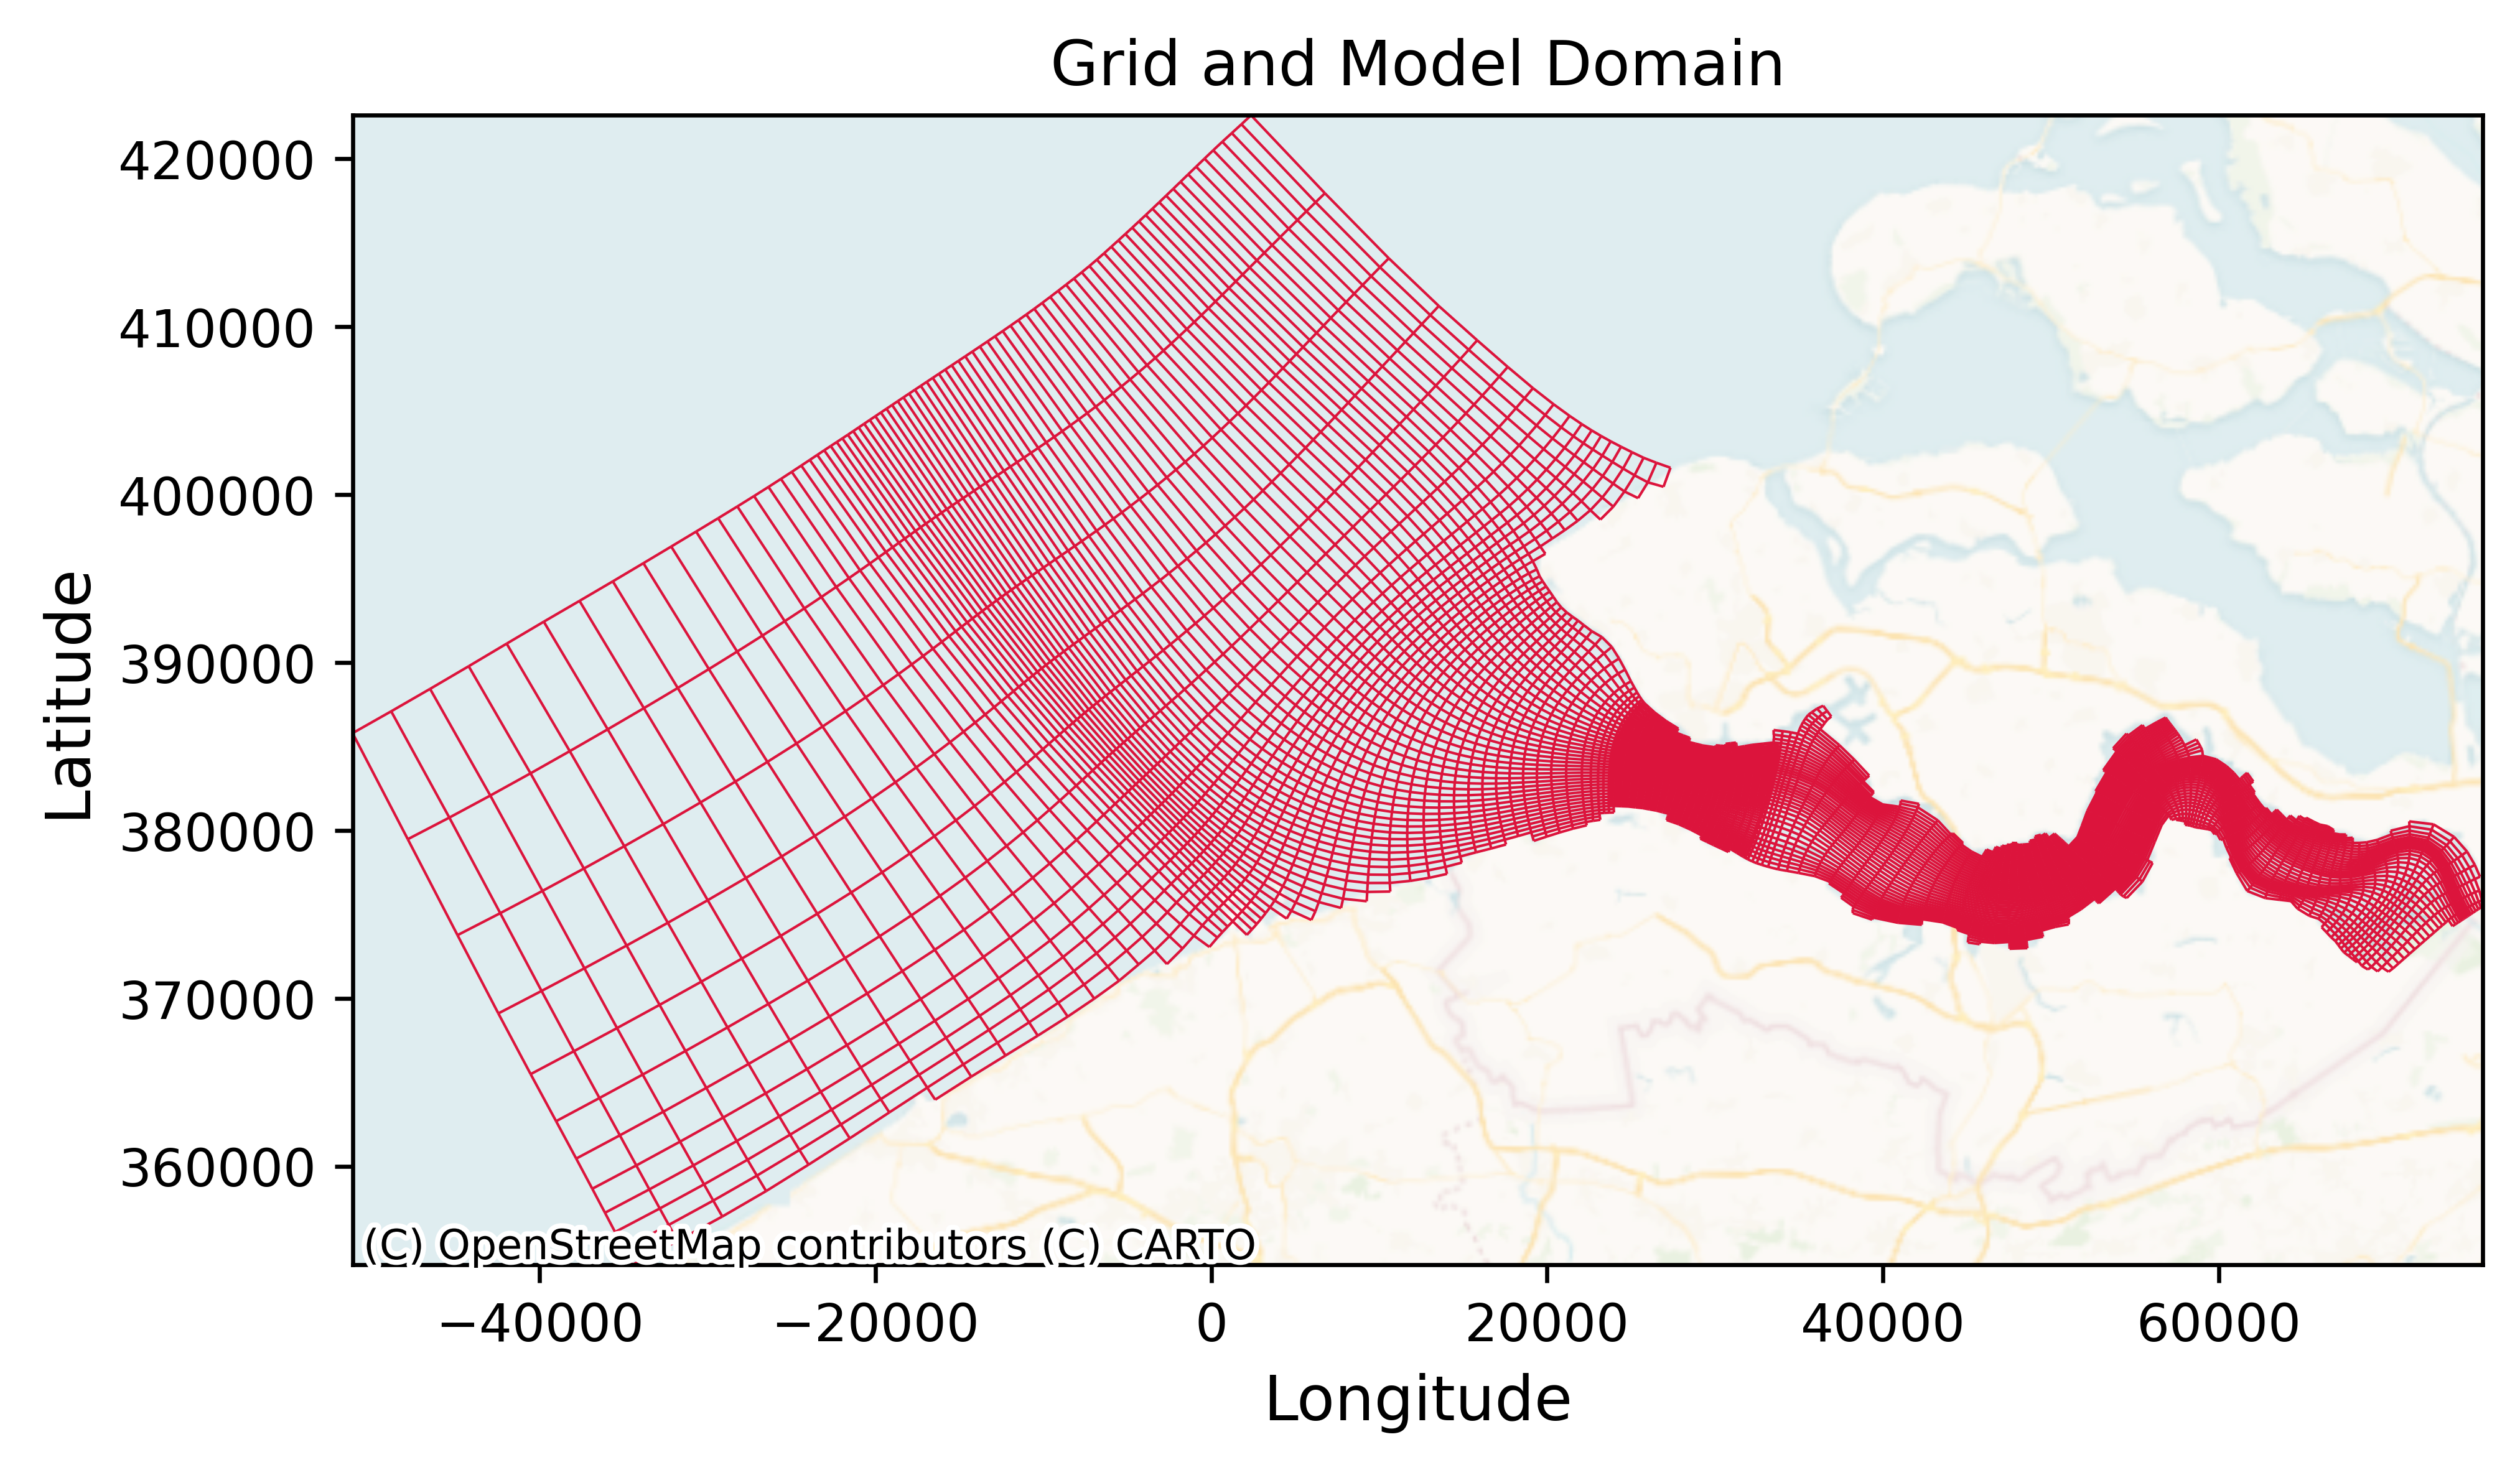

In [131]:
# Plot grid with background of the area

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=600)
uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
ctx.add_basemap(ax, crs='EPSG:28992', source=ctx.providers.CartoDB.VoyagerNoLabels, alpha = 0.75) # Alpha changes the transparency of the basemap
# Above is the basemap. Here are other basemap options (https://contextily.readthedocs.io/en/latest/intro_guide.html)
ax.set_aspect('equal')
ax.set_xlabel('Longitude', fontsize=font_size)
ax.set_ylabel('Latitude', fontsize=font_size)
plt.title('Grid and Model Domain') 
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\figures\grid_and_model_domain.png', bbox_inches='tight') # use bbox to remove white space around image
plt.show()


In [69]:
# save figure
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\grid_and_model_domain.png', bbox_inches='tight') # use bbox to remove white space around image

<Figure size 640x480 with 0 Axes>

In [132]:
# find minimum and maximum depth for plotting depth

min_depth=np.min(uds_map['mesh2d_flowelem_bl'])
print(min_depth.values)
max_depth=np.max(uds_map['mesh2d_flowelem_bl'])
print(max_depth.values)

-46.89282120323986
3.543809298399005


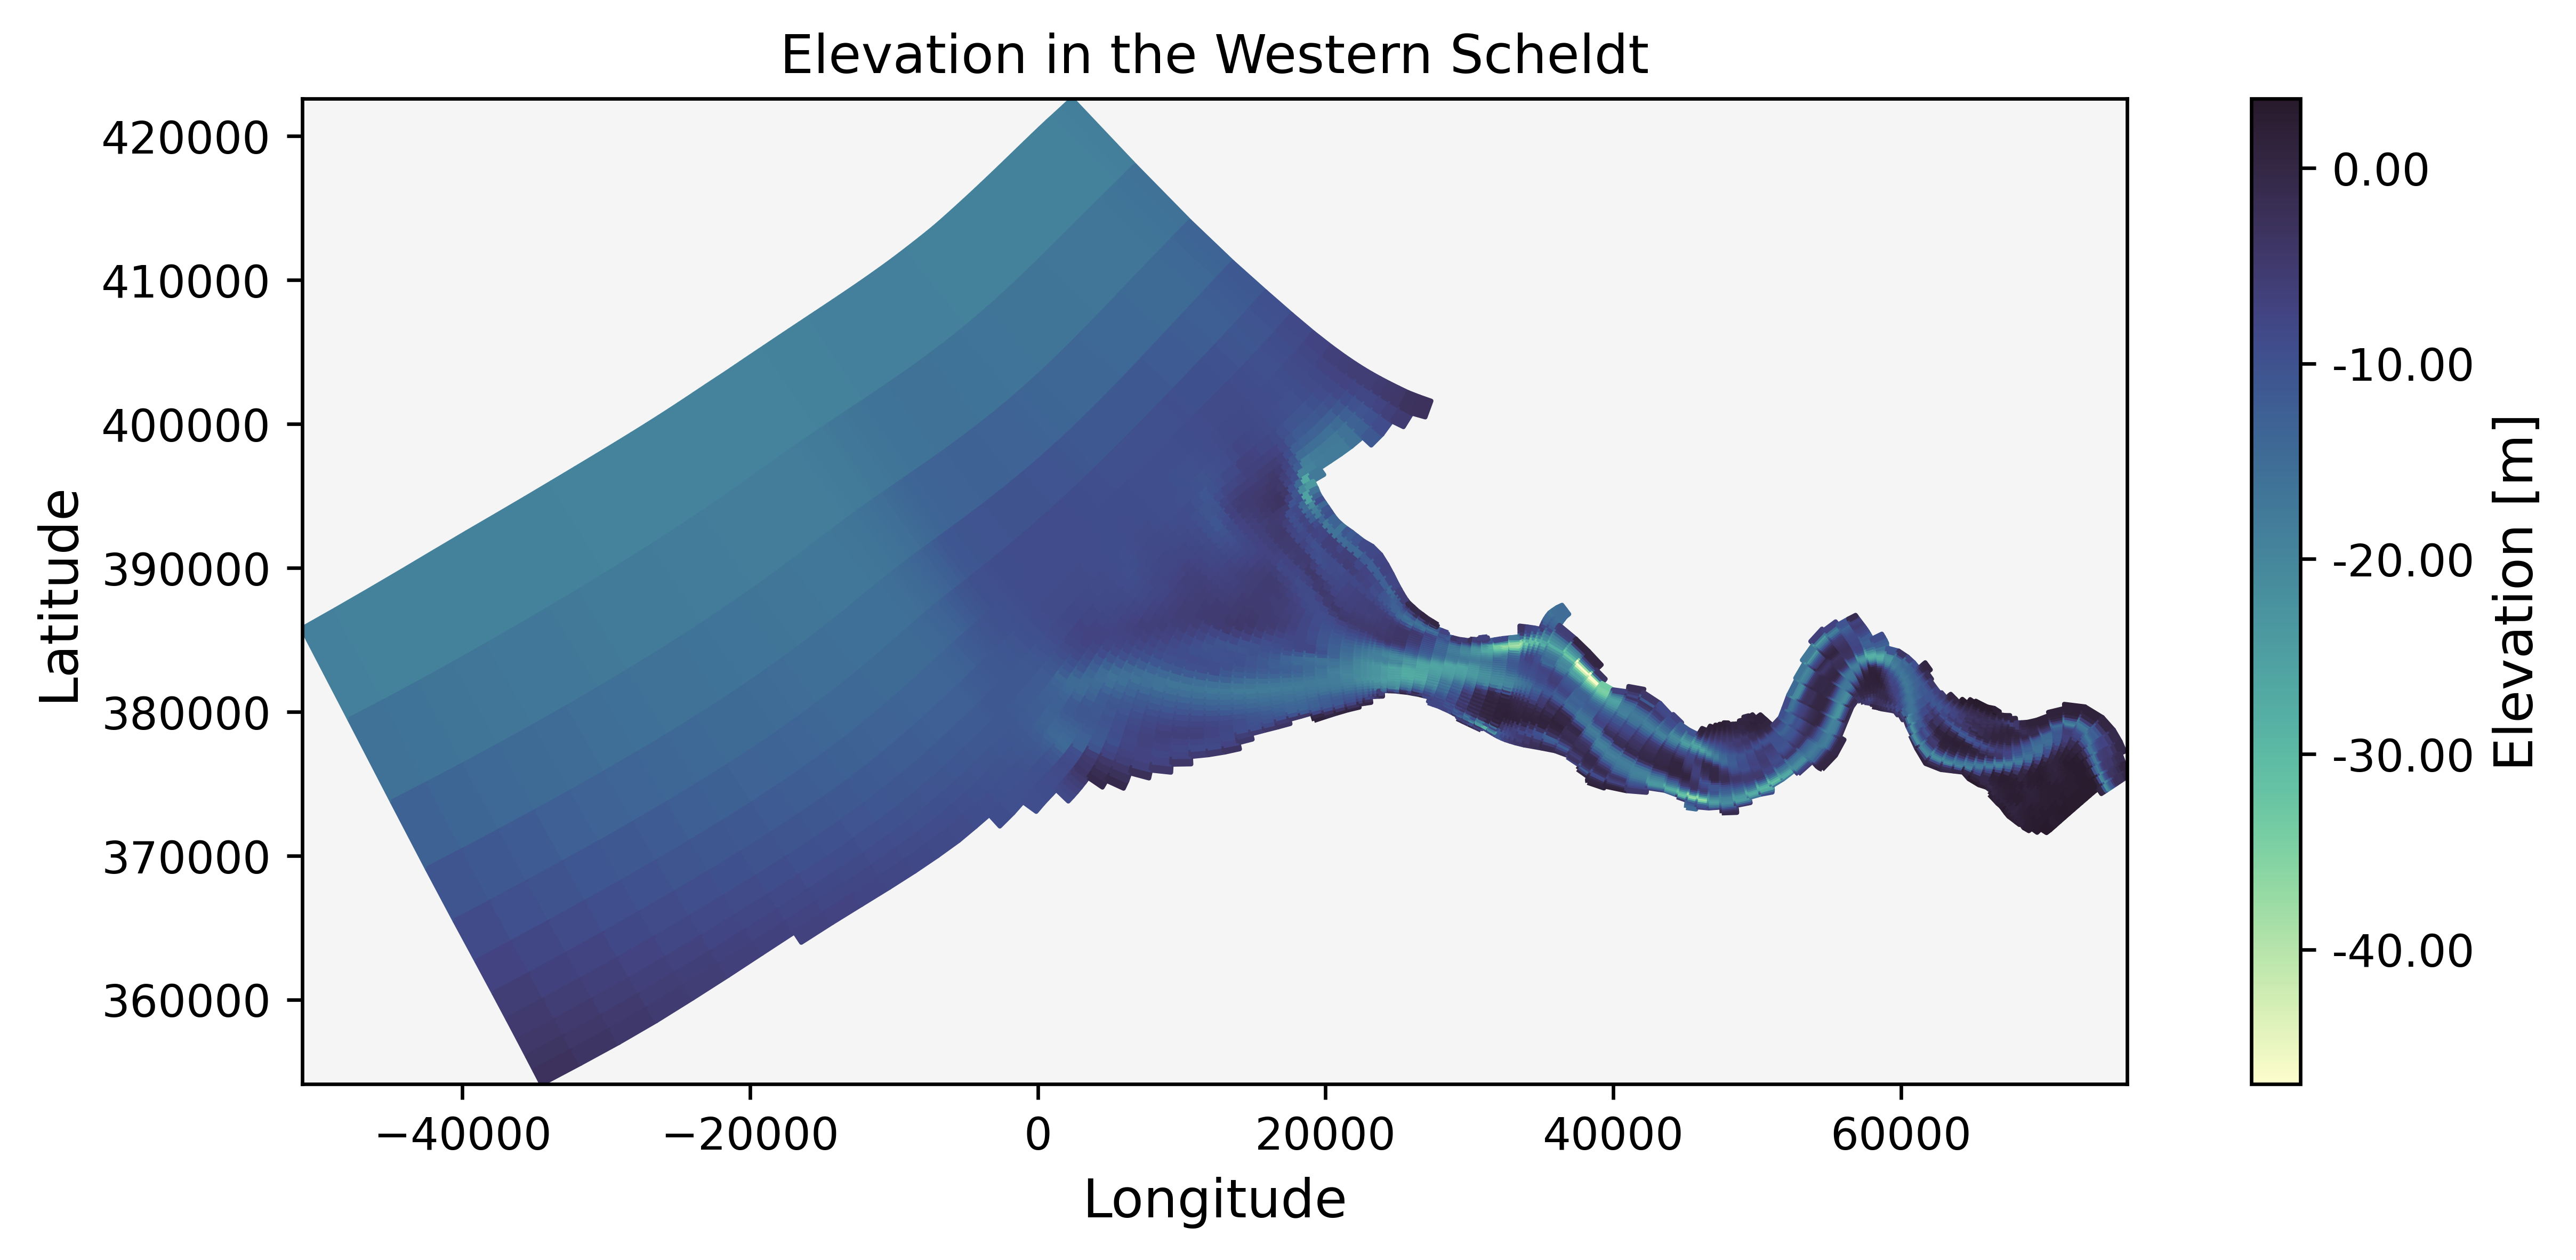

In [133]:
# Depth
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=600)
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot(cmap=cmocean.cm.deep, add_colorbar=False, ax=ax, vmin=min_depth.values, vmax=max_depth.values)
#ctx.add_basemap(ax, crs='EPSG:28992', source=ctx.providers.CartoDB.VoyagerNoLabels, alpha = 0.75) # Alpha changes the transparency of the basemap
# Above is the basemap. Here are other basemap options (https://contextily.readthedocs.io/en/latest/intro_guide.html)
cbar = fig.colorbar(pc, ax=ax)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.set_label('Elevation [m]', fontsize=font_size)
ax.set_aspect('equal')
ax.set_facecolor('whitesmoke')
ax.set_xlabel('Longitude', fontsize=font_size)
ax.set_ylabel('Latitude', fontsize=font_size)
plt.title('Elevation in the Western Scheldt') 
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\figures\initial_depth.png', bbox_inches='tight') # use bbox to remove white space around image
plt.show()

In [134]:
# save figure
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\initial_depth.png', bbox_inches='tight') # use bbox to remove white space around image

<Figure size 640x480 with 0 Axes>

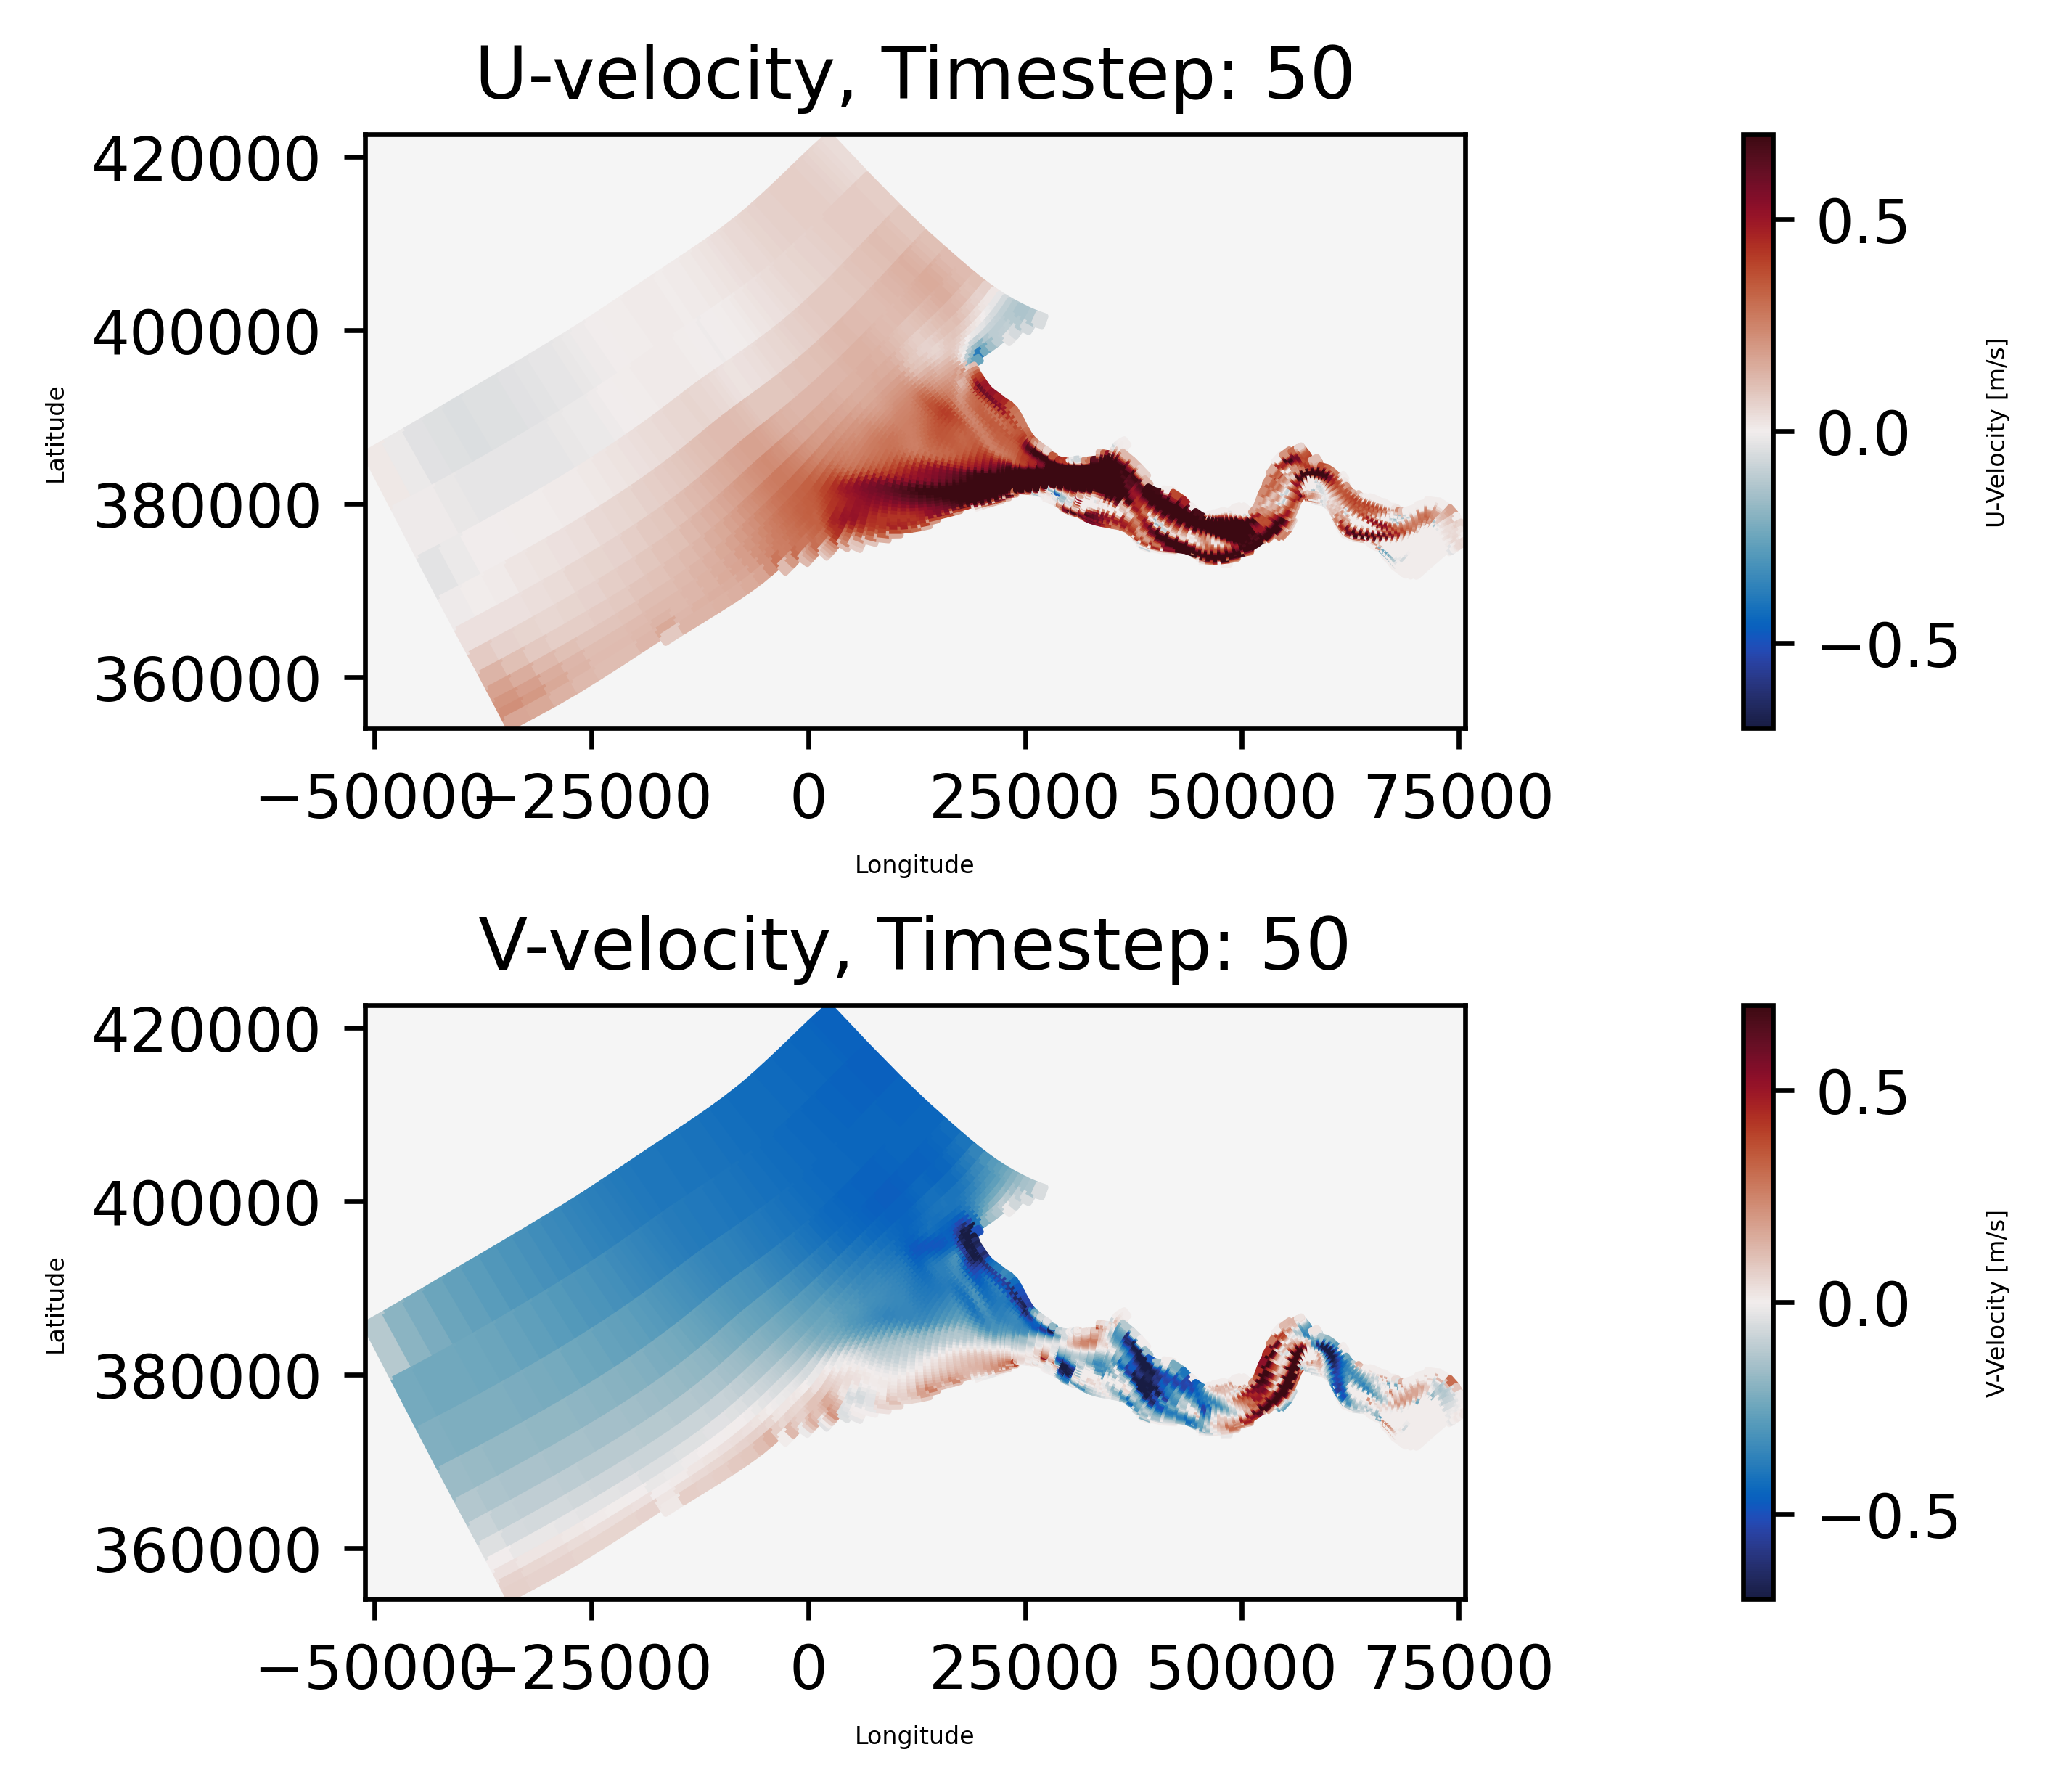

In [89]:
# Velocity at a specific time step

timestep = 50 # You can look at an individual timestep. Lmk if you need a video. I have a seperate code for that.
# U Velocity 
# plt.subplot(1, 2, 1)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fig_width, fig_height), dpi=600,constrained_layout = True)
pc = uds_map['mesh2d_ucx'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.balance, add_colorbar=False, ax=axes[0], vmin=-0.7, vmax=0.7) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[0])
cbar.set_label('U-Velocity [m/s]', fontsize=font_size)
axes[0].set_aspect('equal')
axes[0].set_facecolor('whitesmoke')
axes[0].set_xlabel('Longitude', fontsize=font_size)
axes[0].set_ylabel('Latitude', fontsize=font_size)
axes[0].set_title(f'U-velocity, Timestep: {timestep}')


pc1 = uds_map['mesh2d_ucy'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.balance, add_colorbar=False, ax=axes[1], vmin=-0.7, vmax=0.7) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[1])
cbar.set_label('V-Velocity [m/s]', fontsize=font_size)
axes[1].set_aspect('equal')
axes[1].set_facecolor('whitesmoke')
axes[1].set_xlabel('Longitude', fontsize=font_size)
axes[1].set_ylabel('Latitude', fontsize=font_size)
axes[1].set_title(f'V-velocity, Timestep: {timestep}')
#fig.tight_layout()

# add color bar and adjust location
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cbar = fig.colorbar(pc1, ax=axes[1])
#cbar.set_label('U- & V- Velocity [m/s]', fontsize=font_size)
#fig.colorbar(axes, cax=cbar_ax)
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\figures\u_and_v_velocity.png', bbox_inches='tight') # use bbox to remove white space around image
plt.show()

In [82]:
# save figure
plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\figures\u_and_v_velocity.png', bbox_inches='tight') # use bbox to remove white space around image

<Figure size 640x480 with 0 Axes>

In [122]:
# Now that I have the handle on the data, I will compare the original simulation to one with a "massive" barrier island of vegetation affecting the wind

file_location_veg=r"C:\Users\sbrann5\Downloads\FlowFM_map_080.nc"

map_xr_veg = xr.open_dataset(file_location_veg)
map_xr_veg.rename({})

# read in netcdf file using the dfmt 
file_nc_veg = os.path.join(file_location_veg)
uds_map_veg = dfmt.open_partitioned_dataset(file_nc_veg)
uds_map_veg = uds_map.rename({})
map_vars_pd_veg = dfmt.get_ncvarproperties(uds_map_veg)


>> xu.open_dataset() with 1 partition(s): 1 [nodomainvar] : 0.04 sec


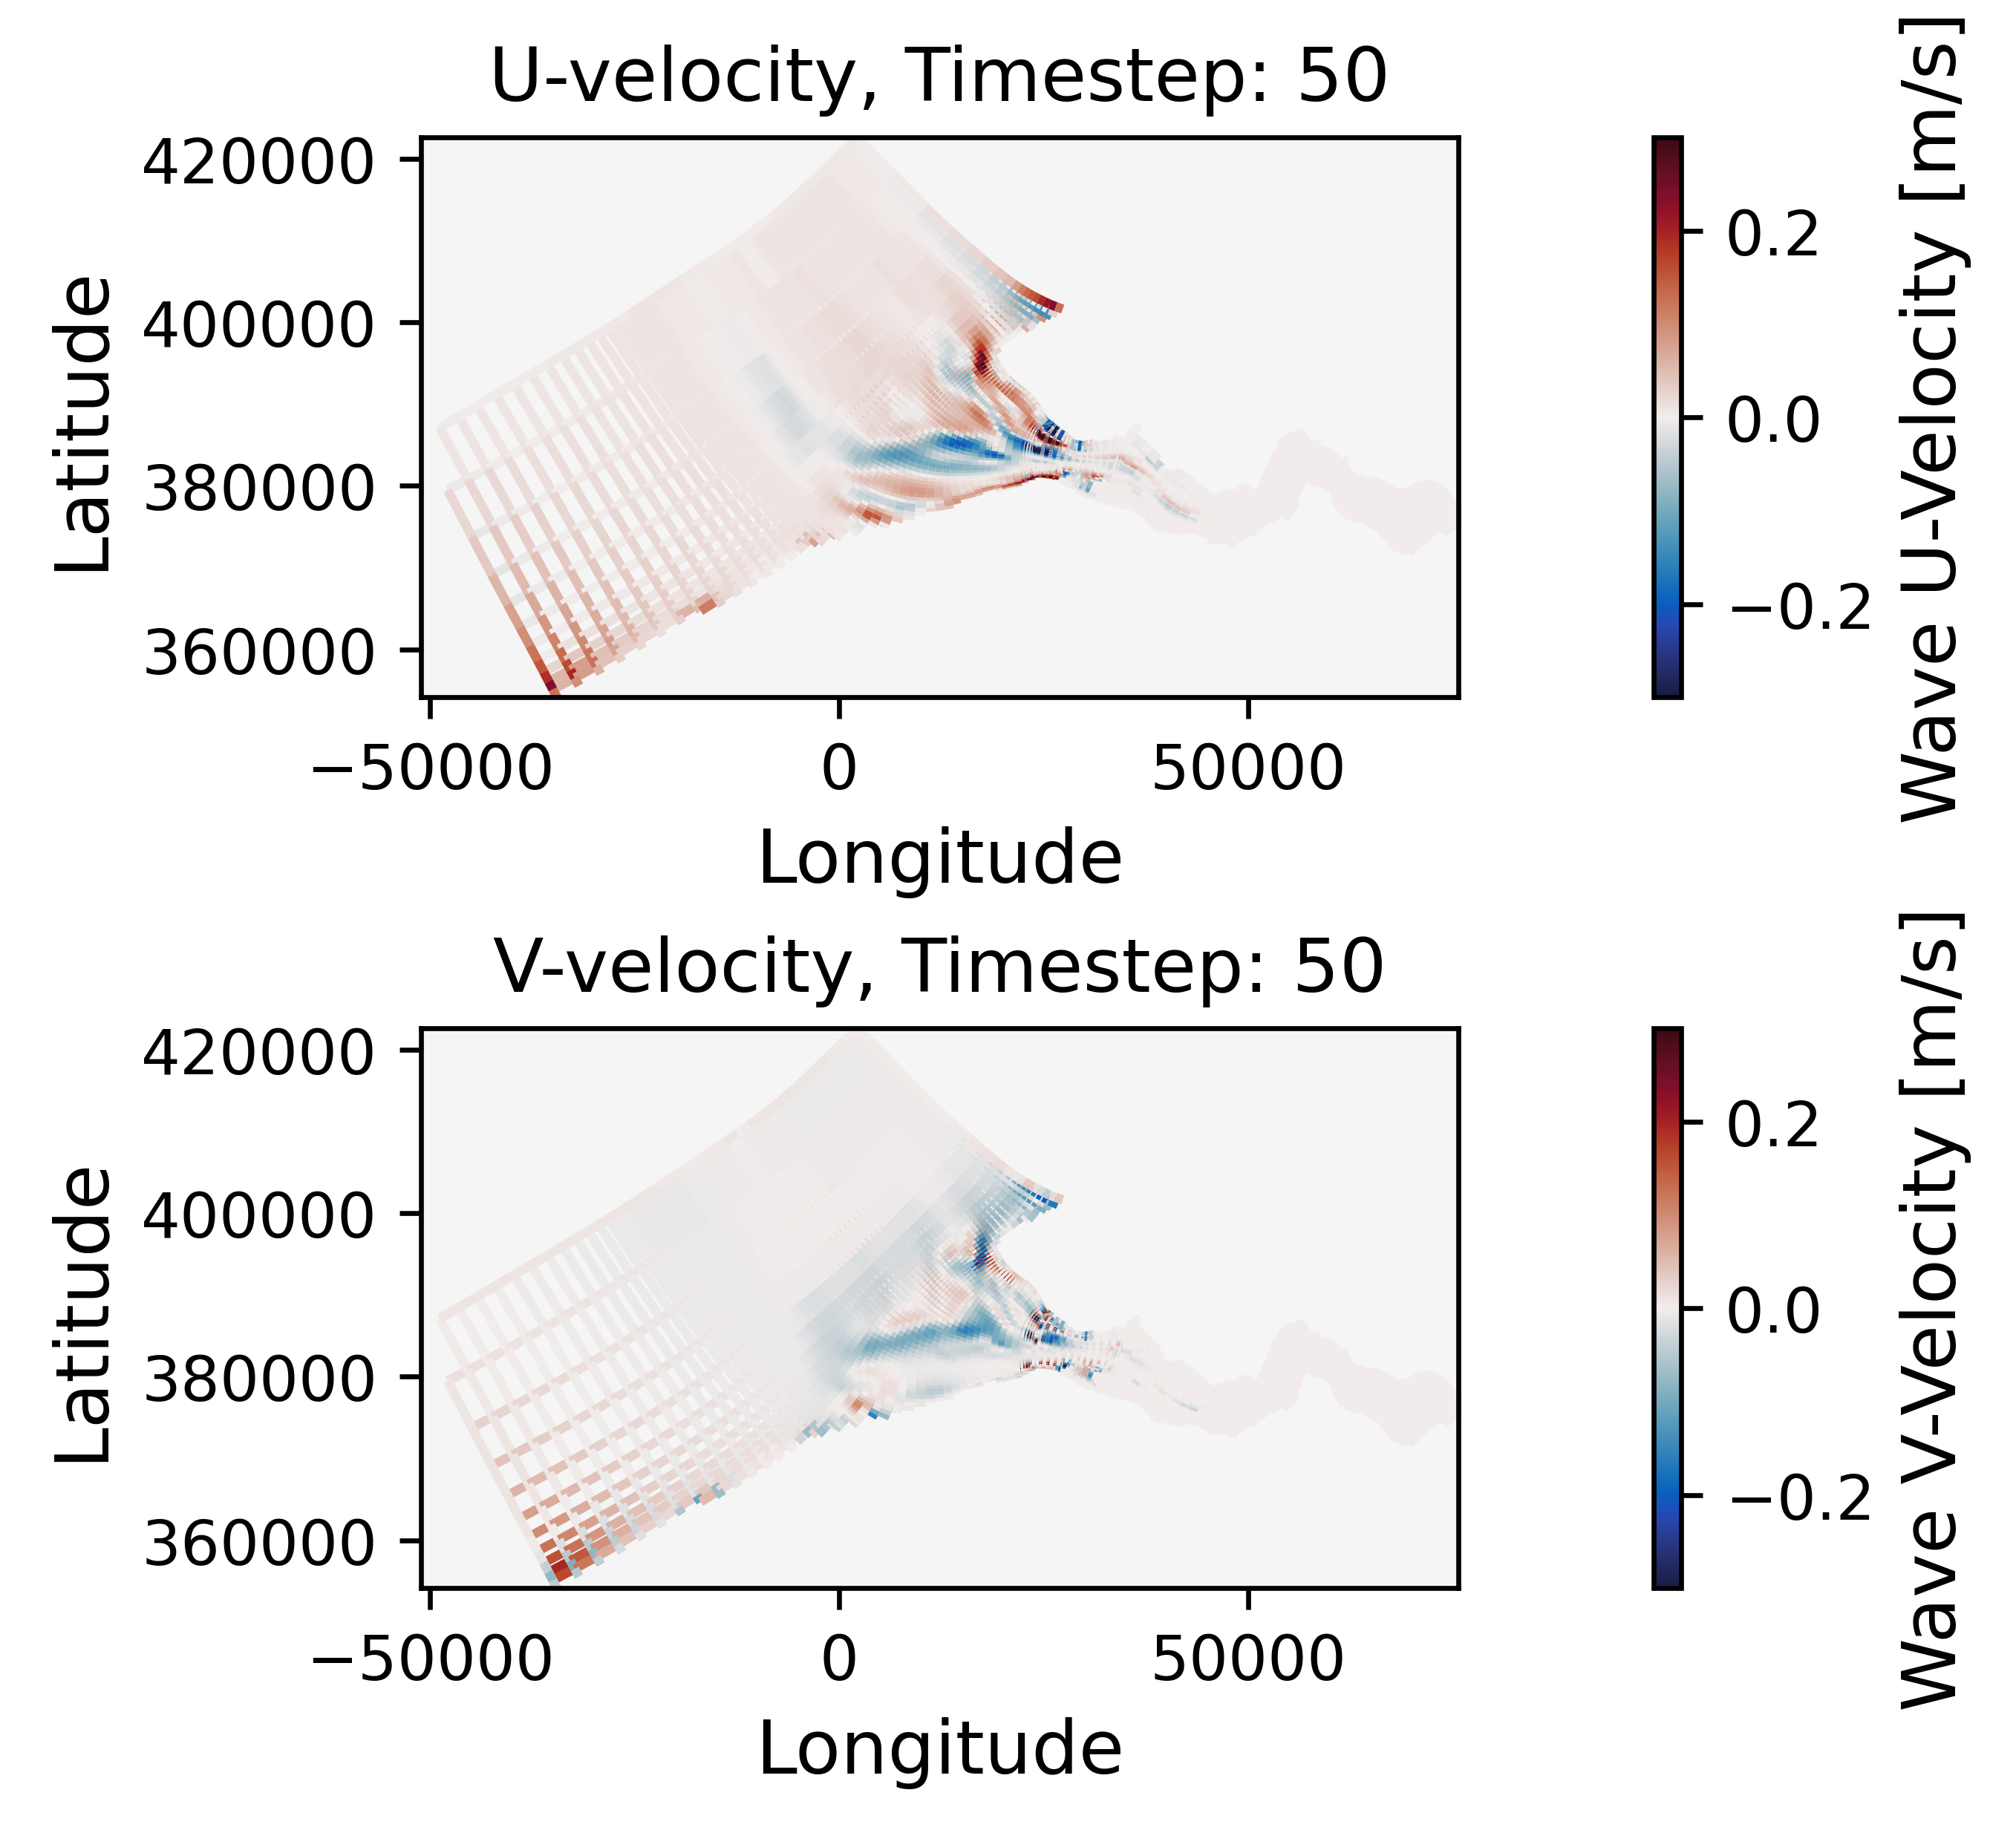

In [123]:
# Wave Velocity at a specific time step
font_size=12
timestep = 50 # You can look at an individual timestep. Lmk if you need a video. I have a seperate code for that.
# U Velocity 
# plt.subplot(1, 2, 1)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fig_width, fig_height), dpi=600,constrained_layout = True)
pc = uds_map_veg['mesh2d_wavfu'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.balance, add_colorbar=False, ax=axes[0], vmin=-0.3, vmax=0.3) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[0])
cbar.set_label('Wave U-Velocity [m/s]', fontsize=font_size)
axes[0].set_aspect('equal')
axes[0].set_facecolor('whitesmoke')
axes[0].set_xlabel('Longitude', fontsize=font_size)
axes[0].set_ylabel('Latitude', fontsize=font_size)
axes[0].set_title(f'U-velocity, Timestep: {timestep}')


pc1 = uds_map_veg['mesh2d_wavfv'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.balance, add_colorbar=False, ax=axes[1], vmin=-0.3, vmax=0.3) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[1])
cbar.set_label('Wave V-Velocity [m/s]', fontsize=font_size)
axes[1].set_aspect('equal')
axes[1].set_facecolor('whitesmoke')
axes[1].set_xlabel('Longitude', fontsize=font_size)
axes[1].set_ylabel('Latitude', fontsize=font_size)
axes[1].set_title(f'V-velocity, Timestep: {timestep}')
#fig.tight_layout()

# add color bar and adjust location
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cbar = fig.colorbar(pc1, ax=axes[1])
#cbar.set_label('U- & V- Velocity [m/s]', fontsize=font_size)
#fig.colorbar(axes, cax=cbar_ax)
#plt.savefig(r'C:\Users\sbrann5\OneDrive - Louisiana State University\May13_backup\Classwork\python_course\final_proj\figures\u_and_v_velocity.png', bbox_inches='tight') # use bbox to remove white space around image
plt.show()

Text(0.5, 1.0, 'No Vegetation, Timestep: 50')

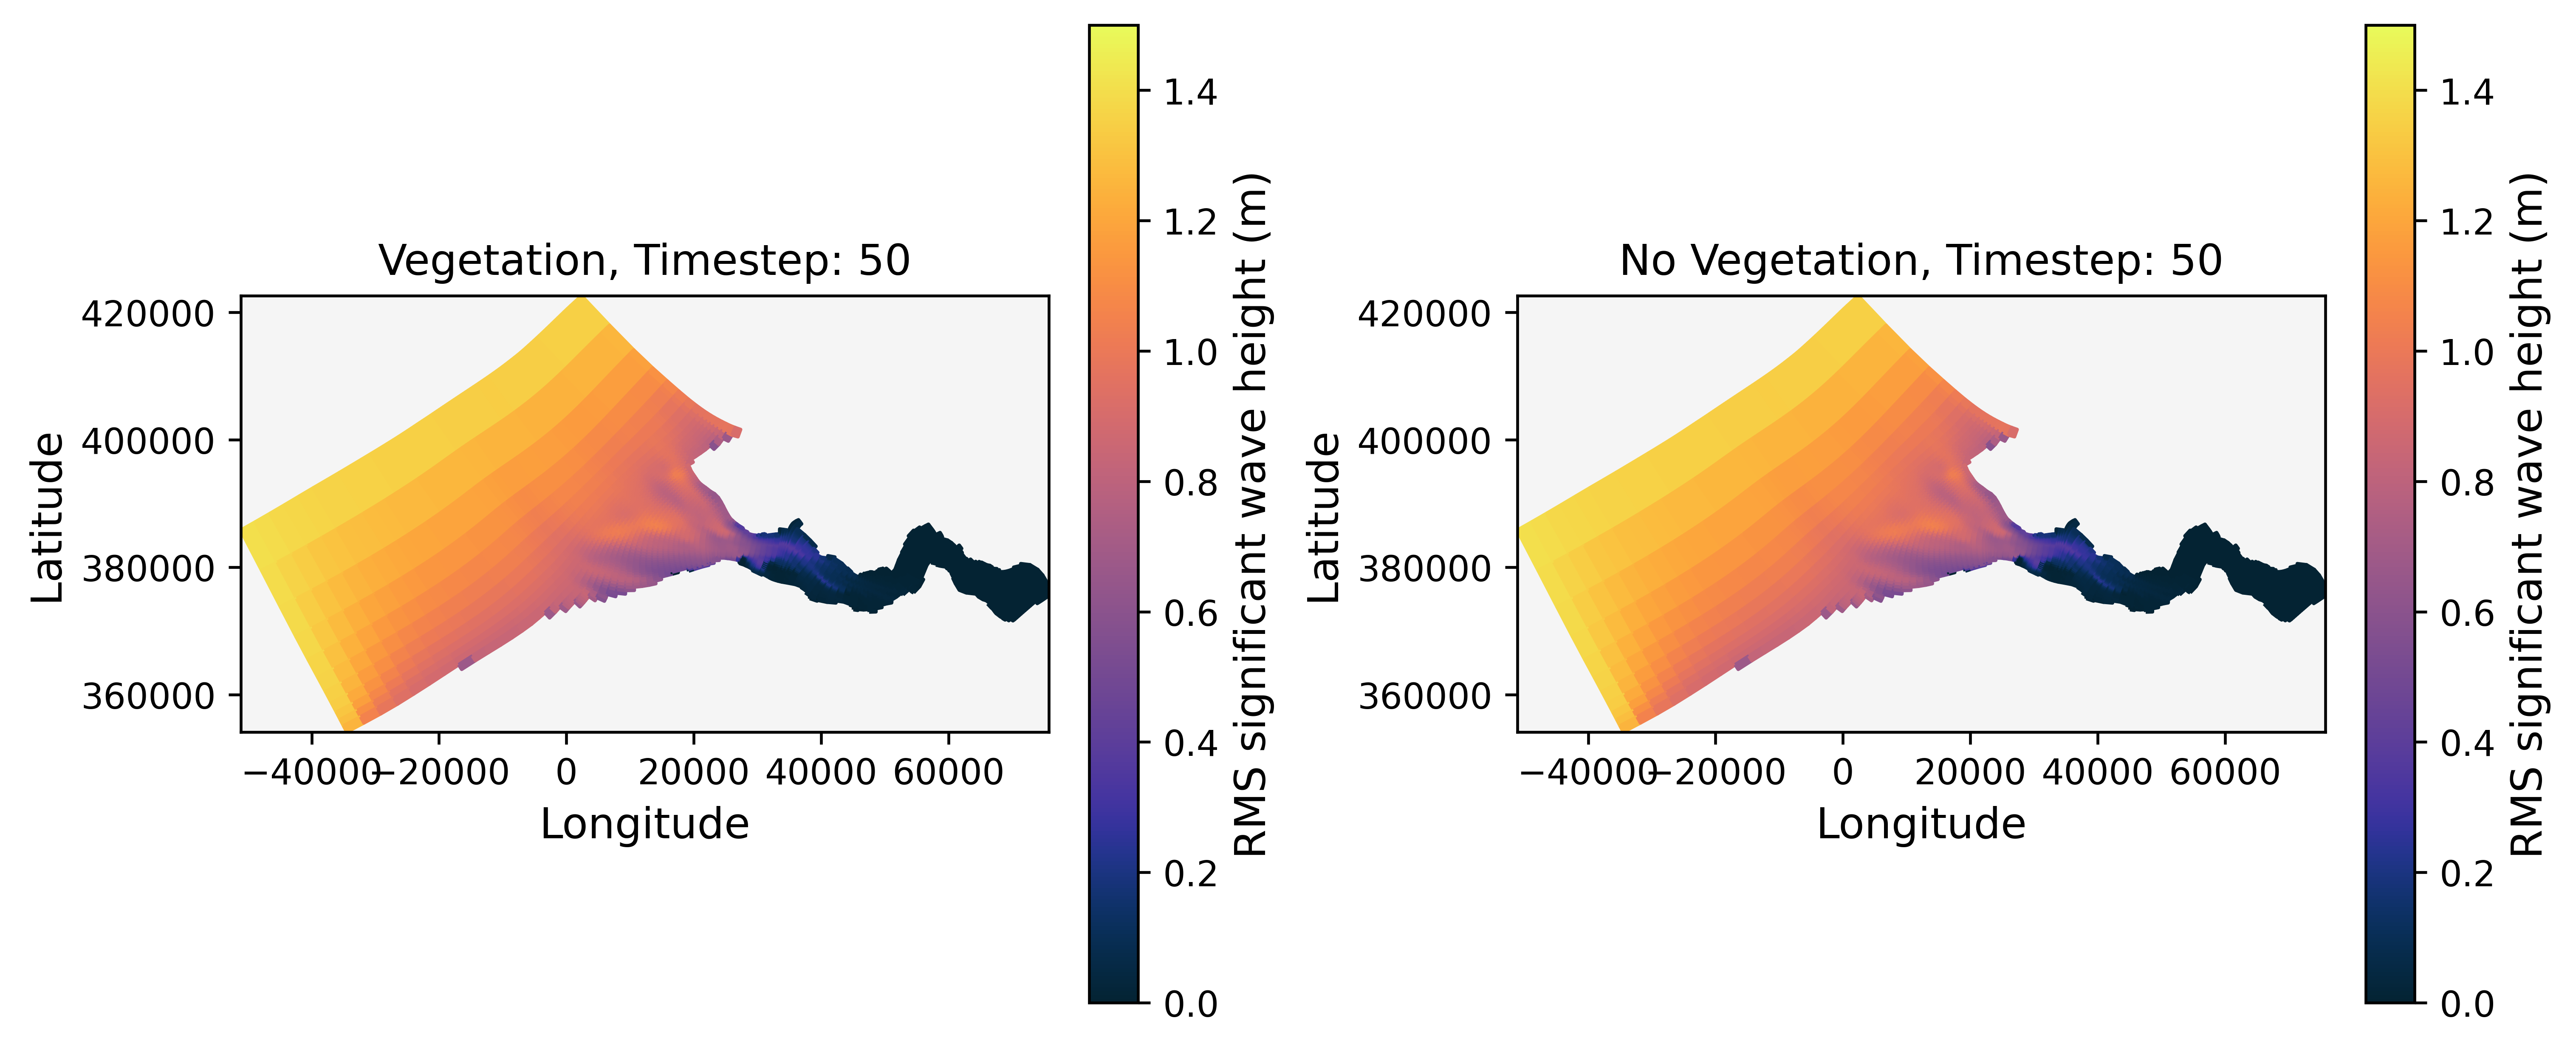

In [135]:

# significant wave height at a specific time step
font_size=12
timestep = 50 # You can look at an individual timestep. Lmk if you need a video. I have a seperate code for that.
# U Velocity 
# plt.subplot(1, 2, 1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, fig_height), dpi=600,constrained_layout = True)
pc = uds_map_veg['mesh2d_hwav'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.thermal, add_colorbar=False, ax=axes[0], vmin=0, vmax=1.5) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[0])
cbar.set_label('RMS significant wave height (m)', fontsize=font_size)
axes[0].set_aspect('equal')
axes[0].set_facecolor('whitesmoke')
axes[0].set_xlabel('Longitude', fontsize=font_size)
axes[0].set_ylabel('Latitude', fontsize=font_size)
axes[0].set_title(f'Vegetation, Timestep: {timestep}')

pc = uds_map['mesh2d_hwav'].isel(time=timestep).ugrid.plot(cmap=cmocean.cm.thermal, add_colorbar=False, ax=axes[1], vmin=0, vmax=1.5) 
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes[1])
cbar.set_label('RMS significant wave height (m)', fontsize=font_size)
axes[1].set_aspect('equal')
axes[1].set_facecolor('whitesmoke')
axes[1].set_xlabel('Longitude', fontsize=font_size)
axes[1].set_ylabel('Latitude', fontsize=font_size)
axes[1].set_title(f'No Vegetation, Timestep: {timestep}')

In [136]:
difference=uds_map_veg['mesh2d_hwav']-uds_map['mesh2d_hwav']

#### DOESNT ACTUALLY SHOW ANYTHING -- MODEL IS WRONG :(

Text(0.5, 1.0, 'Vegetation- no veg, Timestep: 50')

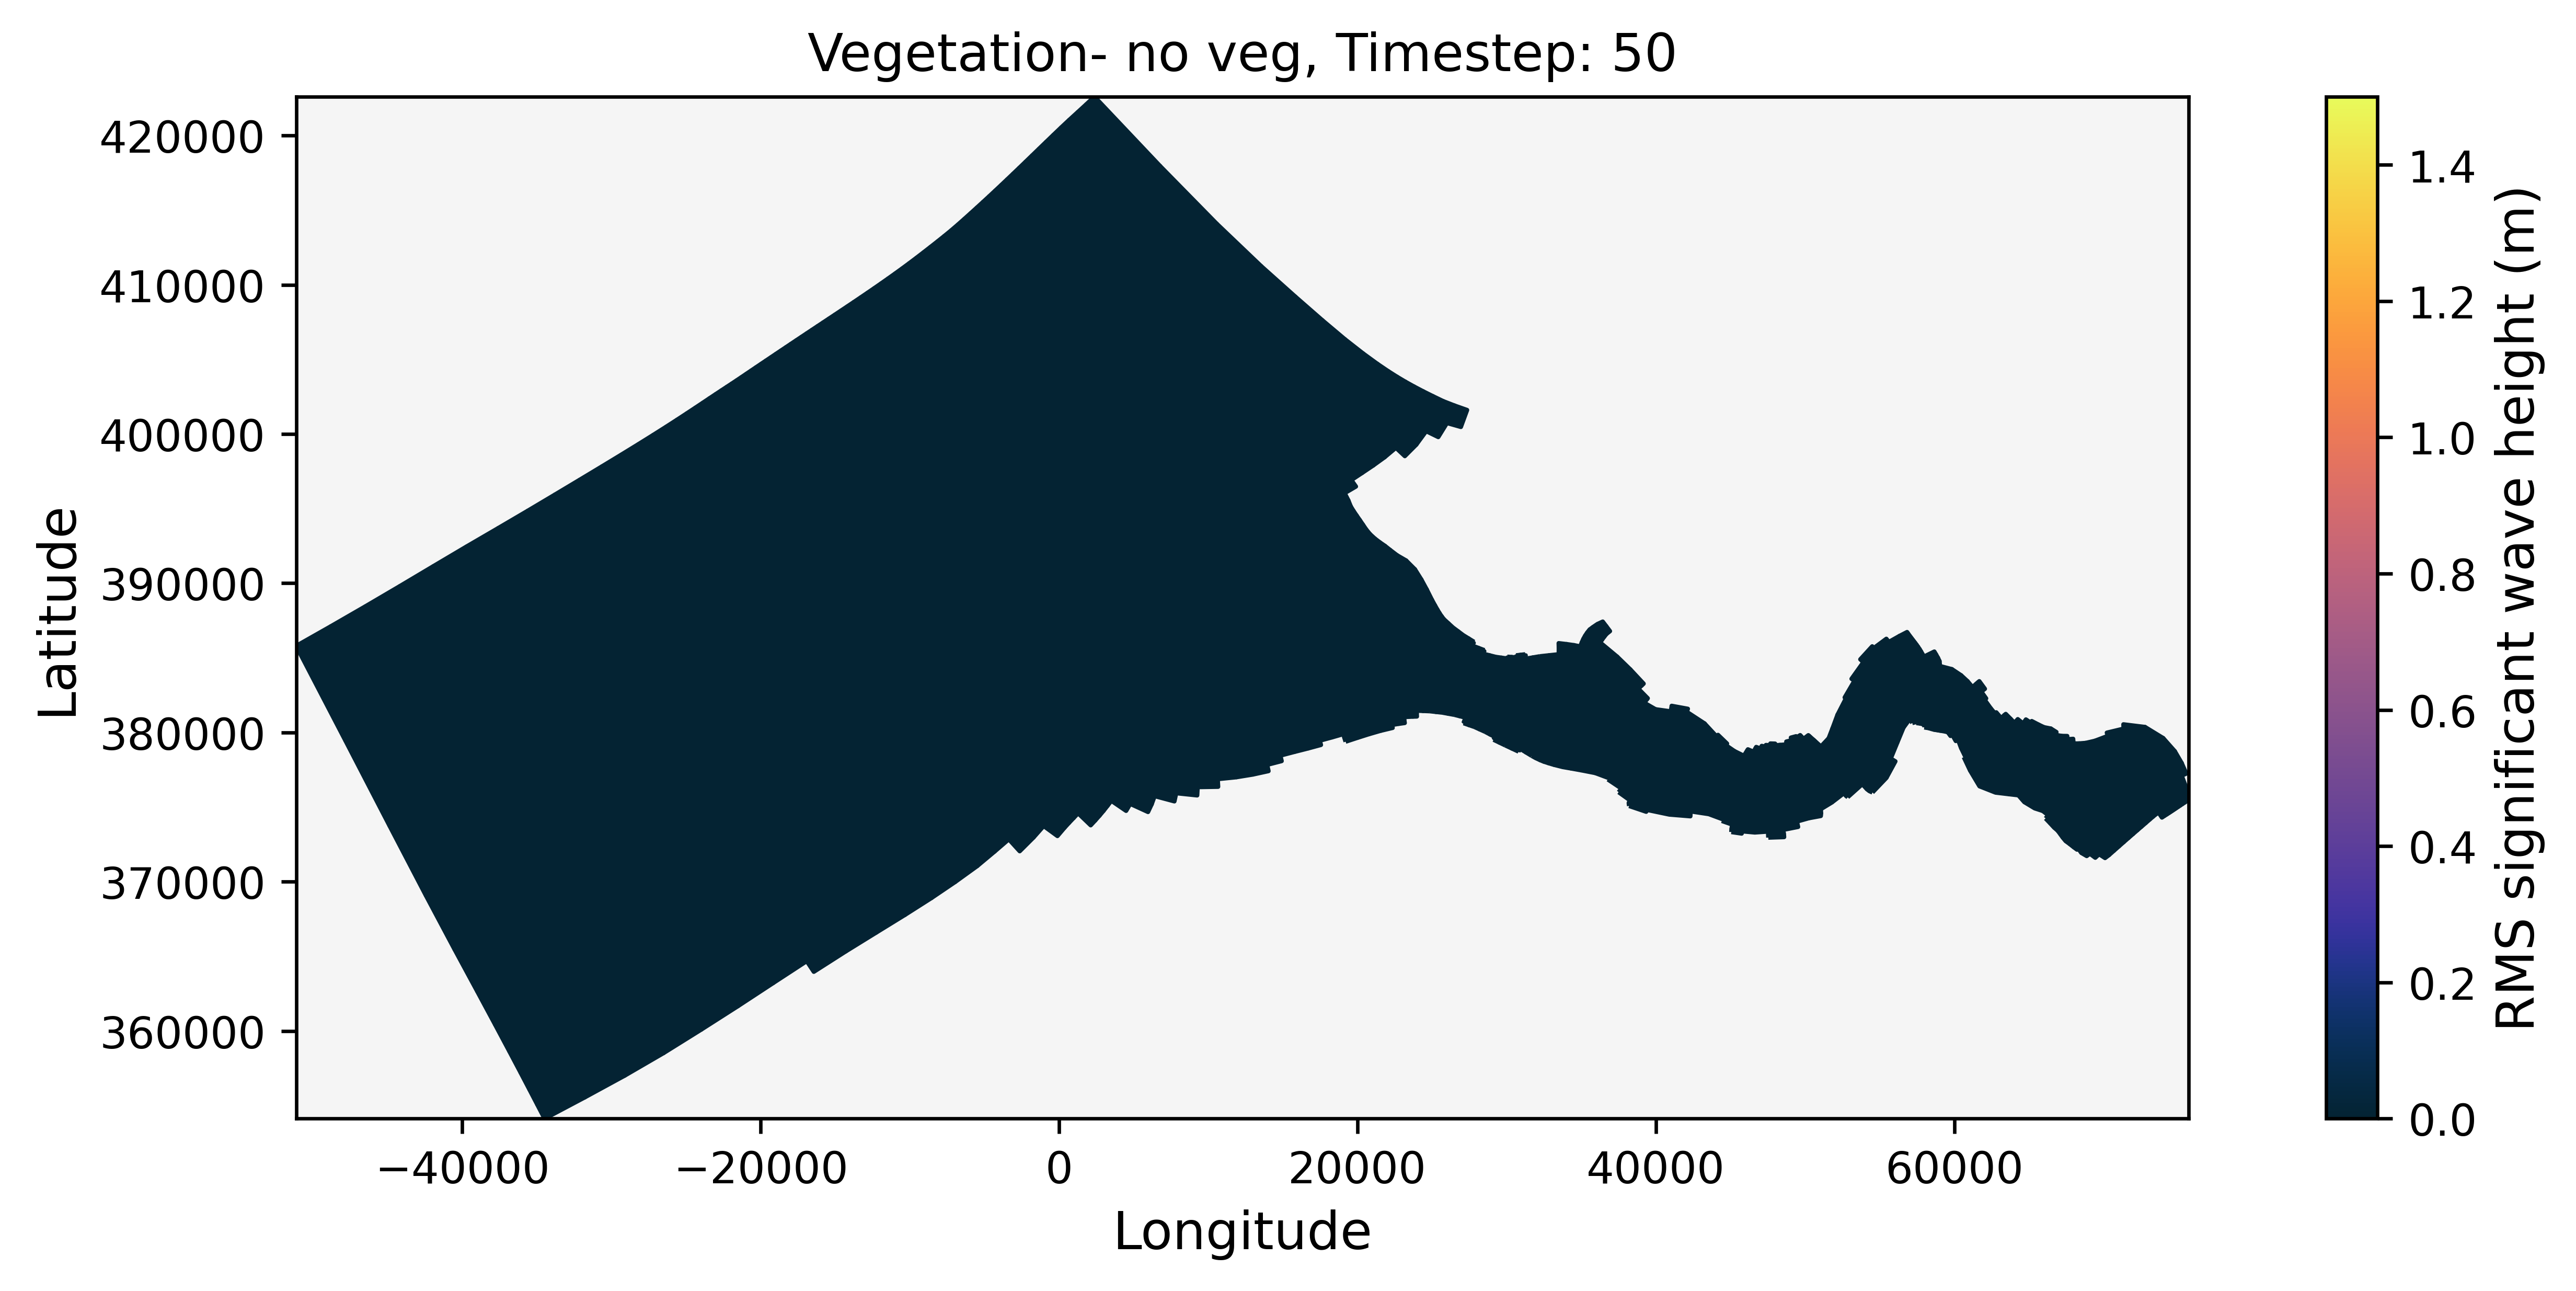

In [137]:
# difference in wave height
difference=uds_map_veg['mesh2d_hwav']-uds_map['mesh2d_hwav']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), dpi=600,constrained_layout = True)
pc = difference.isel(time=timestep).ugrid.plot(cmap=cmocean.cm.thermal, add_colorbar=False, ax=axes, vmin=0, vmax=1.5)
# vmin and vmax need to be the same value (with the min negative) for max and min for white to be at the center
cbar = fig.colorbar(pc, ax=axes)
cbar.set_label('RMS significant wave height (m)', fontsize=font_size)
axes.set_aspect('equal')
axes.set_facecolor('whitesmoke')
axes.set_xlabel('Longitude', fontsize=font_size)
axes.set_ylabel('Latitude', fontsize=font_size)
axes.set_title(f'Vegetation- no veg, Timestep: {timestep}')


>> rasterizing ugrid Dataset with 2 face variables to shape=(68,127): 0.06 sec


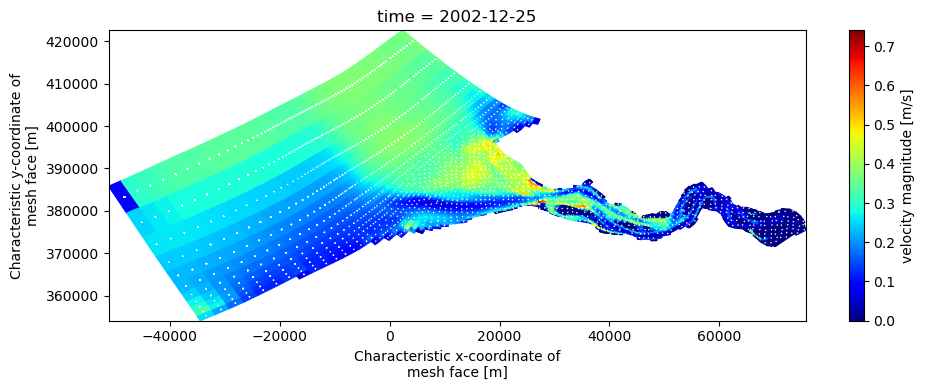

In [154]:
# rasterize image of velocity in domain and add velocity vectors instead of just each direction

##### NEED TO RESIZE VECTORSIN EFFECTIVE WAY
raster_res=1000
scale=100
uds_quiv = uds_map.isel(time=-1, mesh2d_nLayers=-2, nmesh2d_layer=-2, missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

#plot
fig,ax = plt.subplots(figsize=(10,4))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
raster_quiv.plot.quiver(x='mesh2d_face_x',y='mesh2d_face_y',u=varn_ucx,v=varn_ucy,color='w',scale=scale,add_guide=False)
#pc.set_clim(umag_clim)
fig.tight_layout()

In [165]:
# to create inset image ### STILL NEED TO PERFECT

raster_res=1000
scale=100
uds_quiv = uds_map.isel(time=-1, mesh2d_nLayers=-2, nmesh2d_layer=-2, missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs) #find magnitude and direction instead of just components
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

#plot main map
fig,ax = plt.subplots(figsize=(10,4))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
raster_quiv.plot.quiver(x='mesh2d_face_x',y='mesh2d_face_y',u=varn_ucx,v=varn_ucy,color='w',scale=scale,add_guide=False)
#pc.set_clim(umag_clim)
fig.tight_layout()

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define the location and size of the inset (e.g., 0.25 from the right, 0.25 from the top, 0.4 width, 0.4 height)
#inset_ax = inset_axes(ax, width='30%', height='30%', loc='upper right', bbox_to_anchor=(0.75, 0.75, 0.25, 0.25))
inset_ax = inset_axes([x0=20000,y0=370000,width=20000,height=20000])

#plt.plot(ax=inset_ax, edgecolor='k', color='lightblue')
#ax, 
# Set the extent of the inset map (zoom-in on the estuarine region)
inset_extent=[20000, 370000, 40000, 390000]
inset_ax.set_xlim(inset_extent[0], inset_extent[2])
inset_ax.set_ylim(inset_extent[1], inset_extent[3])

from matplotlib.patches import Rectangle
rect = Rectangle((inset_extent[0], inset_extent[1]), inset_extent[2] - inset_extent[0], inset_extent[3] - inset_extent[1],
                  linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Show the plot
plt.show()



SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (696025610.py, line 22)

In [144]:
print(uds_map['mesh2d_edge_y'])

<xarray.DataArray 'mesh2d_edge_y' (mesh2d_nEdges: 12362)> Size: 99kB
dask.array<open_dataset-mesh2d_edge_y, shape=(12362,), dtype=float64, chunksize=(12362,), chunktype=numpy.ndarray>
Coordinates:
    mesh2d_edge_x  (mesh2d_nEdges) float64 99kB dask.array<chunksize=(12362,), meta=np.ndarray>
    mesh2d_edge_y  (mesh2d_nEdges) float64 99kB dask.array<chunksize=(12362,), meta=np.ndarray>
  * mesh2d_nEdges  (mesh2d_nEdges) int64 99kB 0 1 2 3 ... 12359 12360 12361
Attributes:
    units:          m
    standard_name:  projection_y_coordinate
    long_name:      characteristic y-coordinate of the mesh edge (e.g. midpoint)


In [143]:
# plot wave height across a transect ##### STILL NEED TO PERFECT
#(5,58) to (58,58)
wave_height = uds_map['mesh2d_hwav']

#transect=uds_map['mesh2d_edge_nodes']=58
transect=wave_height.sel(uds_map['mesh2d_edge_y']==58)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()